In [1]:
import yfinance as yf
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import openpyxl
import time

In [7]:
SMA = 3
LMA = 15

PVTW = 10
ATRP = 14
MAX_HISTORY_ENTRIES = 50 + 20
PVTW = 10
ATRP = 14

lower_band = 1.2
upper_band = 1.2

In [3]:
symbol = 'TSLA'
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 12, 31)

In [4]:
dft = yf.download(symbol, start=start_date, end=end_date)
df = pd.DataFrame(dft['Close'])
print(df)
print(dft)

[*********************100%***********************]  1 of 1 completed
                 Close
Date                  
2023-01-03  108.099998
2023-01-04  113.639999
2023-01-05  110.339996
2023-01-06  113.059998
2023-01-09  119.769997
...                ...
2023-12-22  252.539993
2023-12-26  256.609985
2023-12-27  261.440002
2023-12-28  253.179993
2023-12-29  248.479996

[250 rows x 1 columns]
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  118.470001  118.800003  104.639999  108.099998  108.099998   
2023-01-04  109.110001  114.589996  107.519997  113.639999  113.639999   
2023-01-05  110.510002  111.750000  107.160004  110.339996  110.339996   
2023-01-06  103.000000  114.389999  101.809998  113.059998  113.059998   
2023-01-09  118.959999  123.519997  117.110001  119.769997  119.769997   
...                ...         ...         ...         ...         ...   
2023-12-22  256.

In [5]:
EXCEL_FILE_PATH = r"C:\Users\David\Desktop\Pilot\END_PRODUCT\price.xlsx"
J_FILE_PATH = r"C:\Users\David\Desktop\Pilot\END_PRODUCT\history.json"

def tke(number):
    data = {"take_profit": number}
    with open(r"C:\Users\David\Desktop\Pilot\END_PRODUCT\TakeProfit.json", 'w') as json_file:
        json.dump(data, json_file)

def read_values_from_j(JSON_FILE_PATH):
    with open(JSON_FILE_PATH, "r") as json_file:
        try:
            data = json.load(json_file)
            data = data[-MAX_HISTORY_ENTRIES:]
        except json.decoder.JSONDecodeError as e:
            print(f"Error decoding JSON at line {e.lineno}, column {e.colno}: {e.msg}")
            raise

    return data

def update_excel_and_save_to_j(data):
    try:
        workbook = openpyxl.load_workbook(EXCEL_FILE_PATH)
        sheet = workbook.active
        sheet.delete_rows(1, sheet.max_row)
        for item in data:
            next_row = sheet.max_row + 1
            sheet.cell(row=next_row, column=1, value=item["timestamp"])
            sheet.cell(row=next_row, column=2, value=item["price"])
        workbook.save(EXCEL_FILE_PATH)
    except FileNotFoundError:
        workbook = openpyxl.Workbook()

def tp_json():
    try:
        with open(r'C:\Users\David\Desktop\Pilot\END_PRODUCT\TakeProfit.json', 'r') as json_file:
            data = json.load(json_file)
            takeprofit = data.get("take_profit")
            return takeprofit
    except FileNotFoundError:
        print("TakeProfit.json not found. Returning None.")
        return None

def sp_json():
    try:
        with open(r'C:\Users\David\Desktop\Pilot\END_PRODUCT\StopLoss.json', 'r') as json_file:
            data = json.load(json_file)
            stoploss = data.get("stop_loss")
            return stoploss
    except FileNotFoundError:
        print("StopLoss.json not found. Returning None.")
        return None

In [6]:
df['SMA'] = df['Close'].rolling(SMA).mean()
df['LMA'] = df['Close'].rolling(LMA).mean()
df['SMAvLMA'] = np.where(df['SMA'] > df['LMA'], 1, 0)
df['ClosevMA20'] = np.where(df['Close'] > df['SMA'], 1, 0)
df['MACD'] = df['SMA'] - df['LMA']
df['SL'] = df['MACD'].rolling(window=9, min_periods=1).mean()
df['High'] = df['Close'].shift(1).cummax()
df['Low'] = df['Close'].shift(1).cummin()
df['TR'] = np.maximum.reduce([
    df['High'] - df['Low'],
    np.abs(df['High'] - df['Close'].shift(1)),
    np.abs(df['Low'] - df['Close'].shift(1))
])
df['ATR'] = df['TR'].rolling(ATRP).mean()
df['StopLoss'] = df['Close'] - 0.2 * df['ATR']
df['TakeProfit'] = df['Close'] + 1.5 * df['ATR']
df['M5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['M20'] = df['Close'].ewm(span=20, adjust=False).mean()

df['Upper Band'] = df['SMA'] + upper_band * df['Close'].rolling(ATRP).std()
df['Lower Band'] = df['SMA'] - lower_band * df['Close'].rolling(ATRP).std()

In [8]:
df

,Close,SMA,LMA,SMAvLMA,ClosevMA20,MACD,SL,High,Low,TR,ATR,StopLoss,TakeProfit,M5,M20,Upper Band,Lower Band
Date,,,,,,,,,,,,,,,,,
2023-01-03,108.099998,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.099998,108.099998,NaN,NaN
2023-01-04,113.639999,NaN,NaN,0,0,NaN,NaN,108.099998,108.099998,0.000000,NaN,NaN,NaN,109.946665,108.627618,NaN,NaN
2023-01-05,110.339996,110.693331,NaN,0,0,NaN,NaN,113.639999,108.099998,5.540001,NaN,NaN,NaN,110.077776,108.790701,NaN,NaN
2023-01-06,113.059998,112.346664,NaN,0,1,NaN,NaN,113.639999,108.099998,5.540001,NaN,NaN,NaN,111.071850,109.197301,NaN,NaN
2023-01-09,119.769997,114.389997,NaN,0,1,NaN,NaN,113.639999,108.099998,5.540001,NaN,NaN,NaN,113.971232,110.204224,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,252.539993,251.393331,245.614666,1,1,5.778665,5.605259,293.339996,108.099998,185.239998,185.239998,215.491994,530.399990,251.840720,244.955352,259.795527,242.991135
2023-12-26,256.609985,254.549993,247.016665,1,1,7.533328,6.373110,293.339996,108.099998,185.239998,185.239998,219.561986,534.469982,253.430475,246.065317,263.114453,245.985533
2023-12-27,261.440002,256.863327,248.531331,1,1,8.331996,7.384073,293.339996,108.099998,185.239998,185.239998,224.392003,539.299999,256.100318,247.529573,265.982831,247.743823


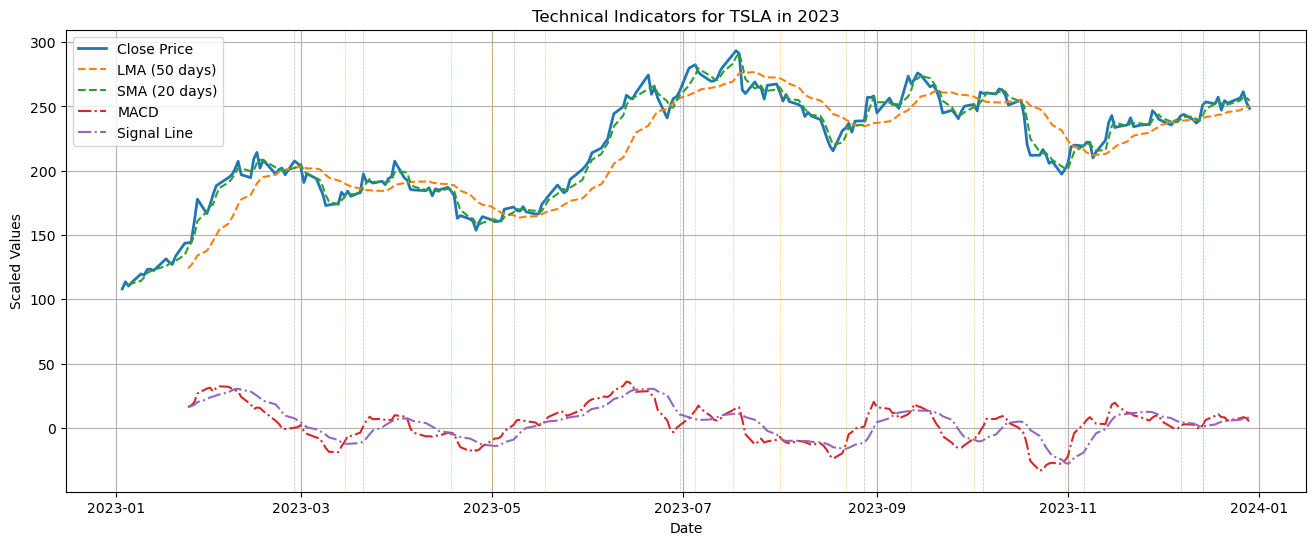

In [9]:
# Find intersections
sma_lma_intersection = df.index[np.where((df['SMA'].shift(1) < df['LMA'].shift(1)) & (df['SMA'] > df['LMA']))]
macd_sl_intersection = df.index[np.where((df['MACD'].shift(1) < df['SL'].shift(1)) & (df['MACD'] > df['SL']))]

# Plot the data
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2)

'''
CUM SA FACI GRAFICE
plt.figure(figsize=(16, 6))
plt.plot(df.index, df[COLOANA DIN DF'], label='COLOANA DIN DF', linewidth=2)
'''
plt.plot(df.index, df['LMA'], label='LMA (50 days)', linestyle='--')
plt.plot(df.index, df['SMA'], label='SMA (20 days)', linestyle='--')
plt.plot(df.index, df['MACD'], label='MACD', linestyle='-.')
plt.plot(df.index, df['SL'], label='Signal Line', linestyle='-.')

# Add vertical gridlines
for date in sma_lma_intersection:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)

for date in macd_sl_intersection:
    plt.axvline(x=date, color='orange', linestyle='--', alpha=0.5, linewidth=0.5)

plt.title('Technical Indicators for TSLA in 2023')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

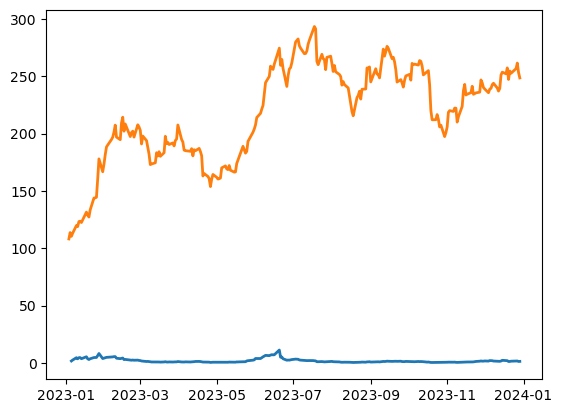

In [10]:
period=25
delta = df['Close'].diff(1)

gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=period, min_periods=1).mean()
avg_loss = loss.rolling(window=period, min_periods=1).mean()
df["RSI"] = 100 - (100/1 - (avg_gain/avg_loss))
plt.plot(df.index, df['RSI'], label='Close Price', linewidth=2)
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2)

<Figure size 1600x600 with 0 Axes>

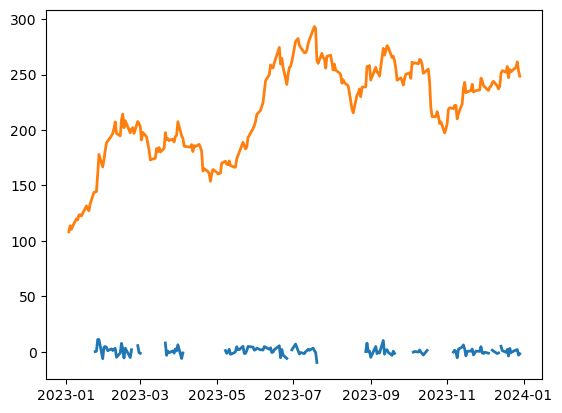

<Figure size 1600x600 with 0 Axes>

In [11]:
df['BPrice'] = (df['Close'] / df['Close'].shift(1) - 1).where(df['SMA'] > df['LMA']) * 100
plt.plot(df.index, df['BPrice'], label='Close Price', linewidth=2)
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2)
plt.figure(figsize=(16, 6))

In [12]:
total_bprice_sum = df['BPrice'].sum()
total_bprice_sum

102.9344096422231

[*********************100%***********************]  6 of 6 completed


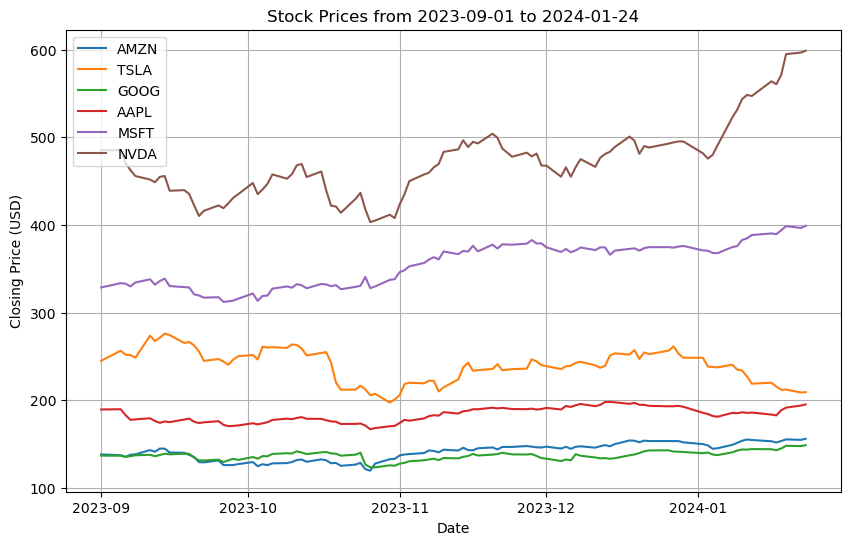

In [14]:
import yfinance as yf
import matplotlib.pyplot as plt

# Define the stock symbols
stocks = ['AMZN', 'TSLA', 'GOOG', 'AAPL', 'MSFT', 'NVDA']  # Add two stocks of your choice below $200

# Define the time period
start_date = '2023-09-01'
end_date = '2024-01-24'

# Fetch historical data
data = yf.download(stocks, start=start_date, end=end_date)

# Plot the closing prices
plt.figure(figsize=(10, 6))
for stock in stocks:
    plt.plot(data.index, data['Close'][stock], label=stock)

plt.title('Stock Prices from {} to {}'.format(start_date, end_date))
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


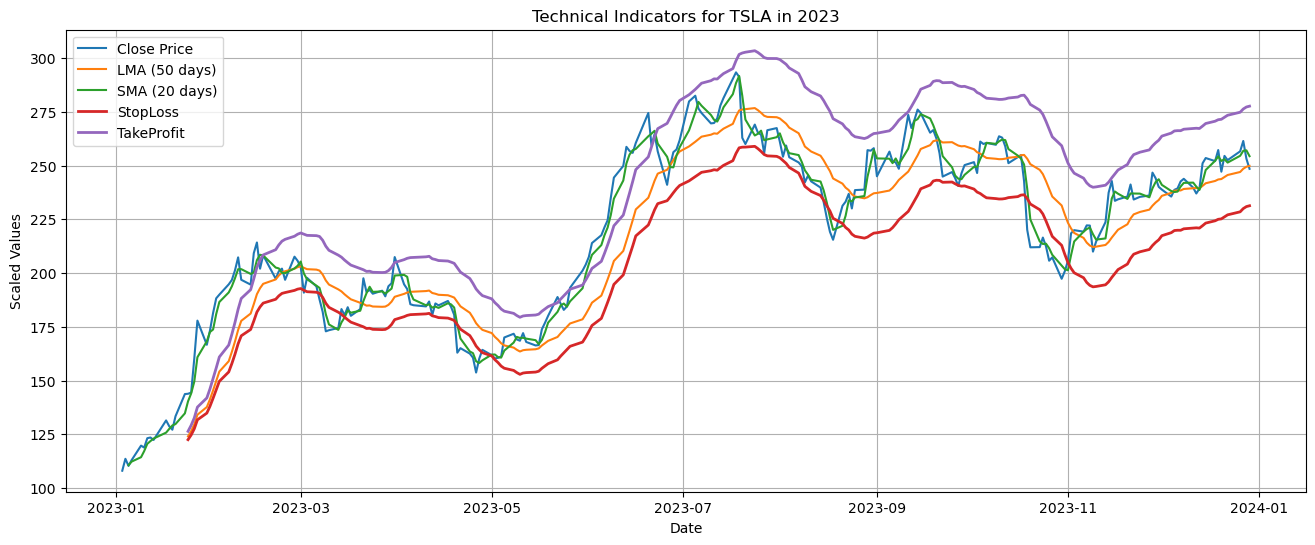

In [15]:
stop_loss_multiplier = 0.1
take_profit_multiplier = 0.15

df['StopLoss'] = df['LMA'] - stop_loss_multiplier * df['ATR']
df['TakeProfit'] = df['LMA'] + take_profit_multiplier * df['ATR']

# Plot the data
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Close Price' )

plt.plot(df.index, df['LMA'], label='LMA (50 days)')
plt.plot(df.index, df['SMA'], label='SMA (20 days)' )

plt.plot(df.index, df['StopLoss'], label='StopLoss', linewidth=2)
plt.plot(df.index, df['TakeProfit'], label='TakeProfit', linewidth=2)
'''
# Add vertical gridlines
for date in sma_lma_intersection:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)

for date in macd_sl_intersection:
    plt.axvline(x=date, color='orange', linestyle='--', alpha=0.5, linewidth=0.5)
'''
plt.title('Technical Indicators for TSLA in 2023')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
j_data = read_values_from_j(J_FILE_PATH)
update_excel_and_save_to_j(j_data)

df1 = pd.read_excel(EXCEL_FILE_PATH, names=['Date', 'Close'])

In [17]:
#BEST SETTINGS FOR TESLA AND LIKESO VOLATILITY
df1['SMA'] = df1['Close'].rolling(SMA).mean()
df1['LMA'] = df1['Close'].rolling(LMA).mean()
df1['SMAvLMA'] = np.where(df1['SMA'] > df1['LMA'], 1, 0)
df1['ClosevMA20'] = np.where(df1['Close'] > df1['SMA'], 1, 0)
df1['Conclusion'] = np.where((df1['SMAvLMA'] >= 1) & (df1['ClosevMA20'] >= 1), 1, 0)
df1['MACD'] = df1['SMA'] - df1['LMA']
df1['SL'] = df['MACD'].rolling(window=9, min_periods=1).mean()
df1['High'] = df['Close'].shift(1).cummax()
df1['Low'] = df['Close'].shift(1).cummin()

df1['TR1'] = df1['High'] - df1['Low']
df1['TR2'] = abs(df1['High'] - df1['Close'].shift(1))
df1['TR3'] = abs(df1['Low'] - df1['Close'].shift(1))
df1['TrueRange'] = df1[['TR1', 'TR2', 'TR3']].max(axis=1)

atr_period = 14
df1['ATR'] = df1['TrueRange'].ewm(span=atr_period, adjust=False).mean()

#df = df.dropna()
#df1 = df1.dropna()
#TSLA best: 0.08(SL), 0.12(TP)


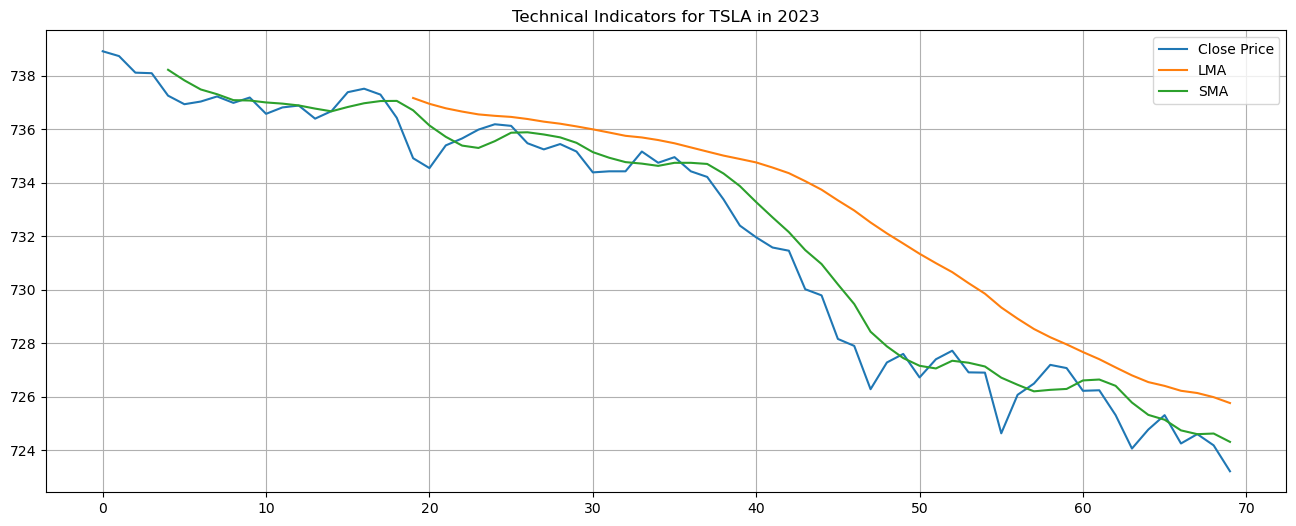

In [18]:
stop_loss_multiplier = 0.6
take_profit_multiplier = 0.2

df1['StopLoss'] = df1['LMA'] - stop_loss_multiplier * df1['ATR']
df1['TakeProfit'] = df1['LMA'] + take_profit_multiplier * df1['ATR']

# Plot the data
plt.figure(figsize=(16, 6))
plt.plot(df1.index, df1['Close'], label='Close Price' )

SMA = 5
LMA = 20

df1['SMA'] = df1['Close'].rolling(SMA).mean()
df1['LMA'] = df1['Close'].rolling(LMA).mean()

plt.plot(df1.index, df1['LMA'], label='LMA')
plt.plot(df1.index, df1['SMA'], label='SMA' )

#plt.plot(df1.index, df1['StopLoss'], label='StopLoss', linewidth=2)
#plt.plot(df1.index, df1['TakeProfit'], label='TakeProfit', linewidth=2)

plt.title('Technical Indicators for TSLA in 2023')
plt.legend()
plt.grid(True)
plt.show()